# NLP to Monitor Social Media for Natural Disasters

This project will use Natural Language Processing (NLP) and Recurrent Neural Networks (RNN) to evaluate social media to classify if a post represents a real natural disaster. Tools like this, even if not totally accurate, could serve as an early warning system for the government or other organizations who might more quickly be able to offer assistance to the people affected by the disaster. 

This project is part of a pathway for a Master's degree from University of Colorado Boulder and also an active contest on Kaggle (which compares the precision and recall of contestants exploring the best neural networks to solve this problem).

To achieve the goals of the contest, I will build and train a few variants of an RNN (like GRU, LSTM), and create a submission file for the contest. The contest provides training files for 10,000 tweets, each hand-classified to label if they are refering to a real natural disaster (1) or not (0).

The initial prerequisite for an RNN is to convert characters and words from users tweeting on X or any other social media into mathematical representations. I will use spaCy, a python library to perform this step because it supports multiple languages, has pre-trained pipelines and supports TensorFlow and Keras, which I will also use for the neural network part.

The initial step is to import necessary libraries, and then we will explore the data.

You can find this notebook on the Kaggle Contest and GitHub:
- [Kaggle Contest](https://www.kaggle.com/code/keithpatton101/natural-language-processing-with-rnn-for-disasters)
- [GitHub Project](https://github.com/kpjava/DeepLearningModule4)


In [80]:
import re
import spacy
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
from keras.preprocessing.sequence import pad_sequences # type: ignore
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau # pyright: ignore[reportMissingImports]
from tensorflow.keras.layers import Input, LSTM, GRU, Dense, Dropout # type: ignore
from tensorflow.keras.models import Sequential, load_model # type: ignore
from tensorflow.keras.optimizers import Adam # type: ignore
from tensorflow.keras.metrics import AUC # type: ignore

## Exploratory Data Analysis (EDA)

I will verify the contents of the CSV files momentarily, but Kaggle provides this description of the data:

#### Files
- train.csv - the training set with columns [id,keyword,location,text,target] where target is the label
- test.csv - the test set with columns [id,keyword,location,text]
- sample_submission.csv - a sample submission file with two columns [id,target]

#### Columns
- id - a unique identifier for each tweet
- text - the text of the tweet
- location - the location the tweet was sent from (may be blank)
- keyword - a particular keyword from the tweet (may be blank)
- target - in train.csv only, this denotes whether a tweet is about a real disaster (1) or not (0)

Let me load the two CSV files, `train_df` and `test_df` and verify its structure.

In [105]:
RUNNING_LOCAL = True
FOLDER_PREFIX = '.' if RUNNING_LOCAL else '/kaggle/input'

raw_df = pd.read_csv(f"{FOLDER_PREFIX}/nlp-getting-started/train.csv", quotechar='"', doublequote=True)
print('train_df.shape:', raw_df.shape)

print('\nNot all of the columns are populated. Here are the counts of each column:')
print(raw_df.count())


train_df.shape: (7613, 5)

Not all of the columns are populated. Here are the counts of each column:
id          7613
keyword     7552
location    5080
text        7613
target      7613
dtype: int64


In [82]:
print('Number of rows with duplicated text:', raw_df.duplicated(subset=['text'], keep=False).sum())

Number of rows with duplicated text: 179


### Distribution of Labels

Let's determine if one label appears more frequently than another. The plot below shows that there are almost 20% fewer texts in the dataset that are related to natural disasters.

(0.0, 1.0)

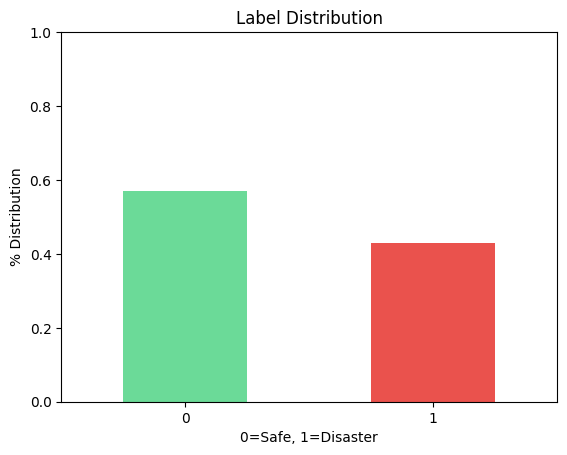

In [83]:
label_colors = ['#6BDA98', '#EA524D']
label_counts = raw_df['target'].value_counts(normalize=True)
ax = label_counts.plot(kind='bar', color=label_colors)
plt.title('Label Distribution')
plt.xlabel('0=Safe, 1=Disaster')
plt.ylabel('% Distribution')
plt.xticks(rotation=0)
plt.ylim(0, 1)


In [84]:
# Calculate class weights to penalize wrong guesses for the majority class (in this case, label=0)
def calc_class_weight(y):
    weight_0_to_1_ratio = y[y==0].count() / y[y==1].count()
    return {0: 1 / weight_0_to_1_ratio, 1: weight_0_to_1_ratio}

### Text Length Distribution

And one more quick analysis to see how the various text lengths are distributed. In the density plot below, we can see that text lengths around 130 characters are more frequent for both labels.

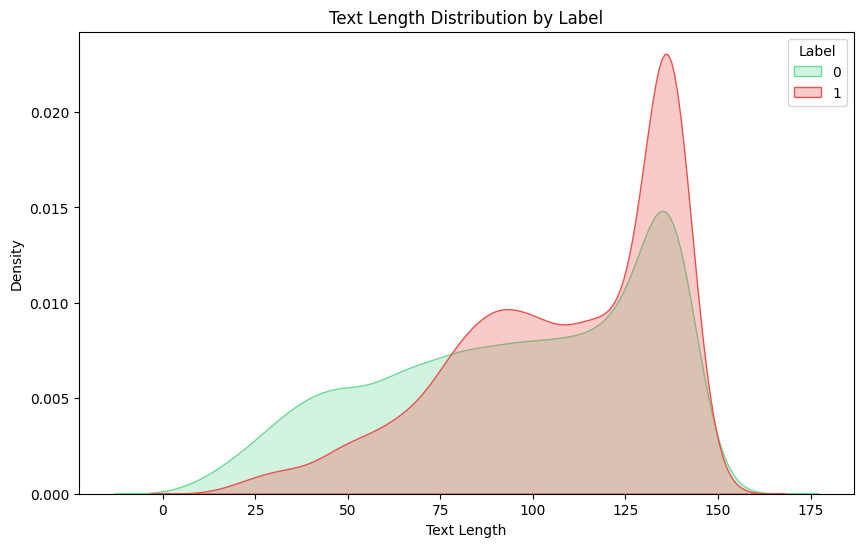

In [85]:
raw_df.loc[:, "length"] = raw_df.loc[:, "text"].apply(len)
plt.figure(figsize=(10, 6))

for category, color in zip([0, 1], label_colors):
    subset = raw_df[raw_df["target"] == category]
    sns.kdeplot(subset["length"], label=category, fill=True, alpha=0.3, color=color)

plt.xlabel("Text Length")
plt.ylabel("Density")
plt.title("Text Length Distribution by Label")
plt.legend(title="Label")
plt.show();

Let's inspect the format of a few sample rows of each label

In [86]:
df_normal = raw_df[raw_df['target'] == 0]
print(f'Here are a few sample rows which are NOT talking about real disasters:\n{"-"*150}')
print("\n".join(df_normal.sample(4, random_state=42)['text']))

df_disaster = raw_df[raw_df['target'] == 1]
print(f'\nHere are a few sample rows which are talking about real disasters:\n{"-"*150}')
print("\n".join(df_disaster.sample(4, random_state=42)['text']))


Here are a few sample rows which are NOT talking about real disasters:
------------------------------------------------------------------------------------------------------------------------------------------------------
Everyday is a near death fatality for me on the road. Thank god is on my side.??
#Lifestyle Û÷It makes me sickÛª: Baby clothes deemed a Û÷hazardÛª http://t.co/0XrfVidxA2 http://t.co/oIHwgEZDCk
@Lenn_Len Probably. We are inundated with them most years!
A demoness with the voice of an angel. Like a siren's call beckoning me to the void. Don't ?? on thisÛ_ https://t.co/nPS3xpBKaQ

Here are a few sample rows which are talking about real disasters:
------------------------------------------------------------------------------------------------------------------------------------------------------
Nearly 50 thousand people affected by floods in #Paraguay ? http://t.co/aw23wXtyjB http://t.co/ABgct9VFUa
Vladimir Putin Issues Major Warning But Is It Too Late To Escape Arm

## Data Preparation

I will perform the following operations to prepare the text for learning:
- Remove rows with text duplicates
- Remove punctuation, and small words (1 or 2 characters)
- Remove @mentions and hyperlinks but keep hashtags (#)
- Convert text to Lowercase to reduce unique word count

In [87]:
print('Removing duplicates...')
deduped_df = raw_df.drop_duplicates(subset=['text']).reset_index()
print('Done. Remaining duplicates:', deduped_df.duplicated(subset=['text'], keep=False).sum())


Removing duplicates...
Done. Remaining duplicates: 0


## Text Preprocessing and Embedding

To utilize text in a neural network the standard practice is to convert each word into a multi-dimensional vector representations where similar words are located near each other. This process is called word embedding. I will use the spaCy library to do the embedding and a custom preprocessing function to remove elements of the text that do not provide much value, such as @mentions and URLs.

The spaCy library has a pre-trained vocabulary `en_core_web_md` that I will use to leverage the thorough training.

The `clean_string()` function will remove URLs and @mentions, and most punctuation, but it will keep hashtags `#` and apostrophes and question marks. It will also lowercase everything to allow us to keep a process a smaller number of tokens.

The danger of processing too many tokens, is that the average tweet will be zero padded and the model will suffer from vanishing gradients.

In [88]:
nlp = spacy.load("en_core_web_md", disable=["tagger", "parser", "ner", "lemmatizer", "attribute_ruler"])

MAX_TOKENS = 30  # Max sequence length (150 tokens/vectors per sample)
EMBEDDING_SIZE = nlp.vocab.vectors_length # 300 for en_core_web_md (GloVe)

def clean_string(s):
    """Removes URLs, mentions, and most punctuation, keeping only letters, spaces, hashtags, and sentiment marks."""
    return re.sub(r"https?:[\S]+|@\S+|[^a-z\s#'!?]", '', s.lower())

def text_embedding(text):
    """Converts a text string into a list of pre-trained word vectors."""
    doc = nlp(clean_string(text)) # Process the cleaned string
    vectors = [token.vector for token in doc if token.has_vector and not token.is_stop]

    if len(vectors) == 0: # Handle the case where a sequence is empty after filtering
        vectors = [np.zeros(EMBEDDING_SIZE, dtype='float32')]

    return vectors[:MAX_TOKENS] # Return the list of vectors, truncated to MAX_TOKENS

def prepare_embedding(text_series):
    """Pad all text-embedded sequences with zeros at the end if shorter than `MAX_TOKENS` and truncated at end if longer."""
    return pad_sequences(
        sequences=text_series.apply(text_embedding),
        maxlen=MAX_TOKENS,
        dtype='float32',
        padding='post',
        truncating='post',
        value=0.0)

X_embedded = prepare_embedding(deduped_df['text'])


### Split for Training and Validating

One more step before we compile and fit a model is to reserve 20% of the preprocessed training data for validation purposes.

In [89]:
y_target = deduped_df['target']
X_train, X_val, y_train, y_val = train_test_split(X_embedded, y_target, test_size=0.2, random_state=42)


## Architecture

I will explore two architectures, both of which are variants of an RNN: Gated Recurrent Unit (GRU) and Long Short-Term Memory (LSTM). Both of these networks are built for processing sequential data. Rather than determining the label simply on the presence of certain words, these networks can also determine the context of a word based on its place in a sequence. 

Additionally, these networks are specifically built to solve the problem of exploding and vanishing gradients.

To utilize these networks, there will be 4 distinct layers:

1. Input Layer: Takes the word embedding vectors

2. RNN Layer: The Recurrent Neural Network core (GRU or LSTM), which outputs a single classification vector

3. Dropout: Regularization applied to the classification vectors to prevent overfitting

4. Final Output Layer: Binary Classification output with sigmoid activation


In [100]:
def build_fit_rnn_model(name, *, rnn_layer, dropout_rate=0.5, learning_rate=0.001):
    model = Sequential([
        Input(shape=(MAX_TOKENS, EMBEDDING_SIZE), name='embedding_input'),
        rnn_layer,
        Dropout(dropout_rate),
        Dense(1, activation='sigmoid'),
    ], name=name)

    optimizer=Adam(learning_rate=learning_rate, use_ema=True)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    return model

def showConfusionMatrix(y_true, y_pred, title):
    """Show a confusion matrix for a given set of predictions"""
    y_pred = (y_pred > 0.5).astype(int)

    cmd = ConfusionMatrixDisplay.from_predictions(
        y_true,
        y_pred,
        display_labels=["Safe", "Disaster"],
        cmap=plt.cm.Blues
    )

    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    total = tn + fp + fn + tp
    f1_score = tp / (tp + ((fn + fp) / 2))
    accuracy = (tn + tp) / total if total > 0 else 0.0 # <-- CALCULATED ACCURACY HERE

    cmd.ax_.set_title(f"Confusion Matrix {title}. Train Accuracy: {accuracy*100:.1f}%, F1: {f1_score:.2f}")


### Train with GRU and Check Confusion

It is now time to build a GRU-specific model, fit it to the train data and generate a confusion matrix on the entire training data to see if any further optimizations are possible.


Model: "RNN_GRU_64"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru_3 (GRU)                     │ (None, 64)             │        70,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 70,337 (274.75 KB)

 Trainable params: 70,337 (274.75 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/15
188/188 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.6683 - loss: 0.6006 - val_accuracy: 0.7402 - val_loss: 0.5443
Epoch 2/15
188/188 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8084 - loss: 0.4426 - val_accuracy: 0.7622 - val_loss: 0.5090
Epoch 3/15
188/188 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8527 - loss: 0.3656 - val_accuracy: 0.7695 - val_loss: 0.5032
Epoch 4/15
188/188 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8817 - loss: 0.3132 - val_accuracy: 0.7675 - val_loss: 0.5965
Epoch 5/15
188/188 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9054 - loss: 0.2701 - val_accuracy: 0.7635 - val_loss: 0.6174
Epoch 6/15
188/188 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9242 - loss: 0.2304 - val_accuracy: 0.7702 - val_loss: 0.7147
Epoch 7/15
188/188 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.9289 - loss: 0.2149 - val_accuracy: 0.7602 - val_loss: 0.7462
Epoch 8/15
188/188 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9379 - loss: 0.2010 - val_accu

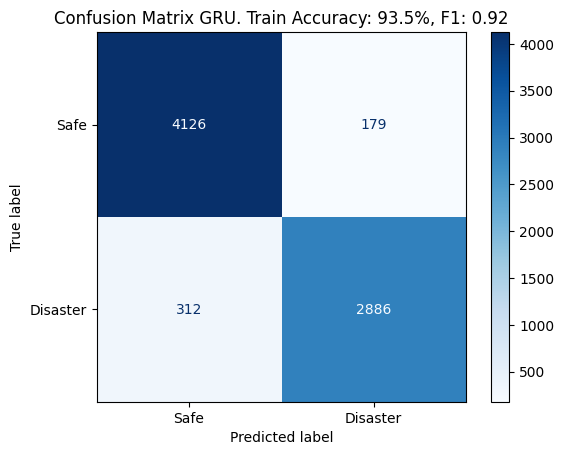

In [97]:
layer_GRU = GRU(64, return_sequences=False)
model_GRU = build_fit_rnn_model('RNN_GRU_64', rnn_layer=layer_GRU)
history_GRU = model_GRU.fit(
    x=X_train,
    y=y_train,
    validation_data=(X_val, y_val),
    batch_size=32,
    epochs=15,
    verbose=1
)
y_pred_GRU = model_GRU.predict(X_embedded)
showConfusionMatrix(y_target, y_pred_GRU, "GRU")

### Results and Analysis of GRU Model

The training accuracy is pretty high, but the validation accuracy is not fantastic at around 75%. This implies that there is overfitting of some type during training. Although the training accuracy steadily climbed, the validation accuracy started to plateau over the later epochs indicating that further epochs were not going to help validation accuracy immensely.

## HYPERTUNING

Before I try an alternative architecture, I will try some hyperparameter tuning to get the ideal settings for the non-RNN layers.

I am using KerasTuner with the Hyperband tuning algorithm.

The Hyperband algorithm will optimize resources by abandoning paths that are not performing well, rather than trying every hyperparameter permutation on a model that is validating poorly. It starts with a large number of random hyperparameter configurations (runners) and trains for only a few epochs. The worst configurations are pruned and the remaining ones are trained for more epochs. After repeating this pruning process, only the best configurations are trained for the full `max_epochs`.

During the tuning process, I will try the following hyperparameters:
- The initial learning rate for the ADAM optimizer (sample in the range .0001 to .01)
- The number of neurons in the GRU layer
- The dropout rate for the last Dense layer that attempts to generalize learning


In [101]:
import keras_tuner as kt

def build_tuned_model(hp):
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
    hp_num_rnn_neurons = hp.Int('rnn_neurons', min_value=32, max_value=96, step=16)
    hp_dropout_rate = hp.Float('dropout_rate', min_value=0.2, max_value=0.6, step=0.1)

    rnn_layer = GRU(hp_num_rnn_neurons, return_sequences=False)
    model = build_fit_rnn_model(f'RNN_GRU_{hp_num_rnn_neurons}', rnn_layer=rnn_layer, dropout_rate=hp_dropout_rate, learning_rate=hp_learning_rate)
    return model

tuner = kt.Hyperband(
    overwrite=True,
    hypermodel=lambda hp: build_tuned_model(hp),
    objective='val_accuracy',
    directory='tuning_results',
    project_name='gru_tuning',
    max_epochs=15,
)

class_weight = calc_class_weight(y_target)
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
adjust_learning = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=2, verbose=1, mode='max', min_lr=0.00001)
model_checkpoint = ModelCheckpoint('best_rnn_model.keras', monitor='val_loss', save_best_only=True),
callbacks = [early_stopping, adjust_learning, model_checkpoint]

tuner.search(
    x=X_train,
    y=y_train,
    validation_data=(X_val, y_val),
    class_weight=class_weight,
    callbacks=callbacks,
    batch_size=32,
    epochs=15,
    verbose=1
)


Trial 30 Complete [00h 00m 27s]
val_accuracy: 0.7628247737884521

Best val_accuracy So Far: 0.7761492133140564
Total elapsed time: 00h 05m 49s


In [ ]:
print("\nTuning complete. Retrieving best hyperparameters...")
print("\nKerasTuner Search Space Summary:")
tuner.search_space_summary()

best_trial = tuner.oracle.get_best_trials(num_trials=1)[0]
best_train_accuracy = best_trial.metrics.get_last_value('accuracy')
best_val_accuracy = best_trial.metrics.get_last_value('val_accuracy')

print(f'\nBest training accuracy: {best_train_accuracy:.1f}%')
print(f'Best validation accuracy: {best_val_accuracy*100:.1f}%')

best_hps = tuner.get_best_hyperparameters(num_trials=1)[0].values
best_rnn_neurons = best_hps.get('rnn_neurons')
best_learning_rate = best_hps.get('learning_rate')
best_dropout_rate = best_hps.get('dropout_rate')

print("\nBest Hyperparameters:")
print(f"    Best rnn_neurons: {best_rnn_neurons}")
print(f"    Best learning rate: {best_learning_rate:.5f}")
print(f"    Best dropout rate: {best_dropout_rate:.5f}")



Tuning complete. Retrieving best hyperparameters...

KerasTuner Search Space Summary:
Search space summary
Default search space size: 3
learning_rate (Choice)
{'default': 0.01, 'conditions': [], 'values': [0.01, 0.001, 0.0001], 'ordered': True}
rnn_neurons (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 96, 'step': 16, 'sampling': 'linear'}
dropout_rate (Float)
{'default': 0.2, 'conditions': [], 'min_value': 0.2, 'max_value': 0.6, 'step': 0.1, 'sampling': 'linear'}

Best validation accuracy: 78.1%

Best Hyperparameters:
    Best rnn_neurons: 64
    Best learning rate: 0.00100
    Best dropout rate: 0.20000


## Alternative RNN - LSTM

The LSTM recurrent layer is an older design than the GRU layer and said to be more complex, but slightly more robust. Let's see how it compares to the GRU

Epoch 1/15
188/188 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - accuracy: 0.7557 - loss: 0.5206 - val_accuracy: 0.7781 - val_loss: 0.4843
Epoch 2/15
188/188 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.8279 - loss: 0.4105 - val_accuracy: 0.7881 - val_loss: 0.4839
Epoch 3/15
188/188 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8569 - loss: 0.3509 - val_accuracy: 0.7795 - val_loss: 0.5154
Epoch 4/15
188/188 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8789 - loss: 0.2951 - val_accuracy: 0.7875 - val_loss: 0.4917
Epoch 5/15
188/188 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9024 - loss: 0.2575 - val_accuracy: 0.7595 - val_loss: 0.6523
Epoch 6/15
188/188 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9130 - loss: 0.2302 - val_accuracy: 0.7668 - val_loss: 0.6599
Epoch 7/15
188/188 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9287 - loss: 0.1924 - val_accuracy: 0.7615 - val_loss: 0.7214
Epoch 8/15
188/188 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9382 - loss: 0.1711 - val_accu

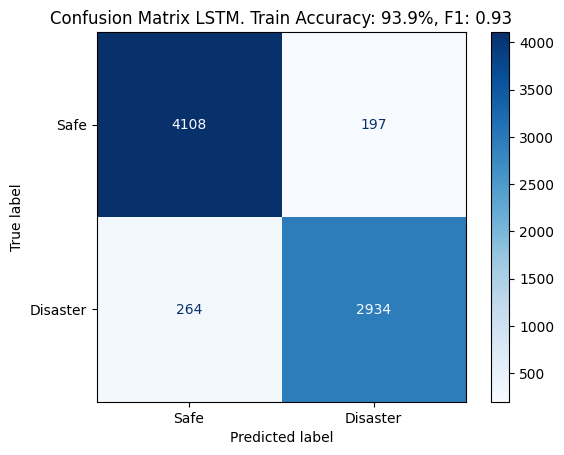

In [102]:
# best_model = load_model('best_rnn_model.keras')
layer_LSTM = LSTM(best_rnn_neurons, return_sequences=False)
model_LSTM = build_fit_rnn_model('RNN_LSTM_64', rnn_layer=layer_LSTM, dropout_rate=best_dropout_rate, learning_rate=best_learning_rate)
class_weight = calc_class_weight(y_target)
history_LSTM = model_LSTM.fit(
    x=X_train,
    y=y_train,
    validation_data=(X_val, y_val),
    batch_size=32,
    epochs=15,
    verbose=1
)
y_pred_LSTM = model_LSTM.predict(X_embedded)
showConfusionMatrix(y_target, y_pred_LSTM, "LSTM")

### Results & Analysis¶
From the confusion matrices displayed above, we can see that that both models performed similarly on the training and validation datasets. The LSTM model outperformed the GRU, but only slightly.

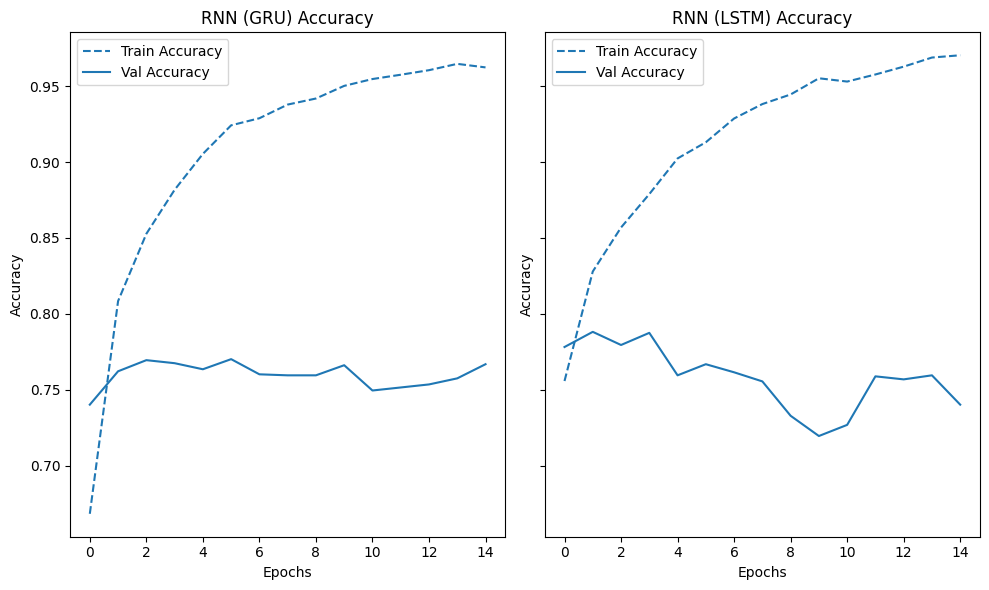

In [111]:
def plot_accuracy(model, ax, title):
    ax.plot(model.history['accuracy'], label='Train Accuracy', color='#1f77b4', linestyle='dashed')
    ax.plot(model.history['val_accuracy'], label='Val Accuracy', color='#1f77b4')
    ax.set_title(f'RNN ({title}) Accuracy')
    ax.set_xlabel('Epochs')
    ax.set_ylabel('Accuracy')
    ax.legend()

fig, axes = plt.subplots(1, 2, figsize=(10, 6), sharey=True)

# Plot history_basic
plot_accuracy(history_GRU, axes[0], "GRU")
plot_accuracy(history_LSTM, axes[1], "LSTM")

plt.tight_layout()
plt.show()

### Prepare Submission

To prepare a submission for the Kaggle contest, I will read there test.csv, and use the `best_model` to predict the target values. The result will be saved as submission.csv and submitted to the Kaggle contest.

In [106]:
best_model = load_model('best_rnn_model.keras')
test_df = pd.read_csv(f"{FOLDER_PREFIX}/nlp-getting-started/test.csv", quotechar='"', doublequote=True)

X_test = prepare_embedding(test_df['text'])
y_pred_test = best_model.predict(X_test)

submission_df = pd.DataFrame({
    'id': test_df['id'],
    'target': [1 if v > 0.5 else 0 for v in y_pred_test.flatten()]
})
submission_df.to_csv('submission.csv', index=False)

102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


## Conclusion

In this project, I explored a RNN with a GRU layer achieving good training accuracy, but not ideal validation accuracy.

Prior to building the models, I performed natural language processing with the library, spaCy to convert the textual tweets into embedded vectors with spaCy's vast training of vocabulary. I used the embedded vectors in the RNN.

I then tuned the hyperparameters of the RNN with KerasTuner and the Hyperband search strategy. With the optimized parameters, I then tried an alternative model using an LSTM layer. Training that model showed very slight improvement over the GRU layer.

I then prepared a submission for the Kaggle contest and submitted my results to their leaderboard.

### Credits:
- [Quick Tutorial on Kaggle for using an NLP](https://www.kaggle.com/philculliton/nlp-getting-started-tutorial)

- [Sequence Classification with LSTM Recurrent Neural Networks in Python with Keras](https://machinelearningmastery.com/sequence-classification-lstm-recurrent-neural-networks-python-keras/)

- [Keras TextVectorization layer](https://keras.io/api/layers/preprocessing_layers/text/text_vectorization/)
